# Traffic Dataset Experiment Results Visualization

This notebook loads and visualizes the results from the traffic dataset experiments conducted with multiple random seeds. 

The experiments compare:
- PoFM (Product of Feature Matrices) kernel baseline
- Exact Diffusion kernel baseline  
- GRF (Gaussian Random Field) with diffusion-shaped modulation
- A-GRF (Arbitrary GRF) with learned modulation function

Results are shown with error bars/shadows representing variability across different random seeds.

## Setup and Data Loading

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Configuration
RESULTS_FILE = "results/traffic_experiment_results.csv"
# Use same color palette as BO notebook for consistency
COLORS = sns.color_palette("colorblind", n_colors=5)
COLOR_MAPPING = {
    'GRF': COLORS[4],      # blue-ish
    'A-GRF': COLORS[0],    # orange-ish
    'PoFM': COLORS[3],     # green-ish
    'Diffusion': COLORS[2] # red-ish (more distinct from A-GRF)
}

GRF: RGB(204, 120, 188) / Hex: #cc78bc
A-GRF: RGB(1, 115, 178) / Hex: #0173b2
PoFM: RGB(213, 94, 0) / Hex: #d55e00
Diffusion: RGB(2, 158, 115) / Hex: #029e73


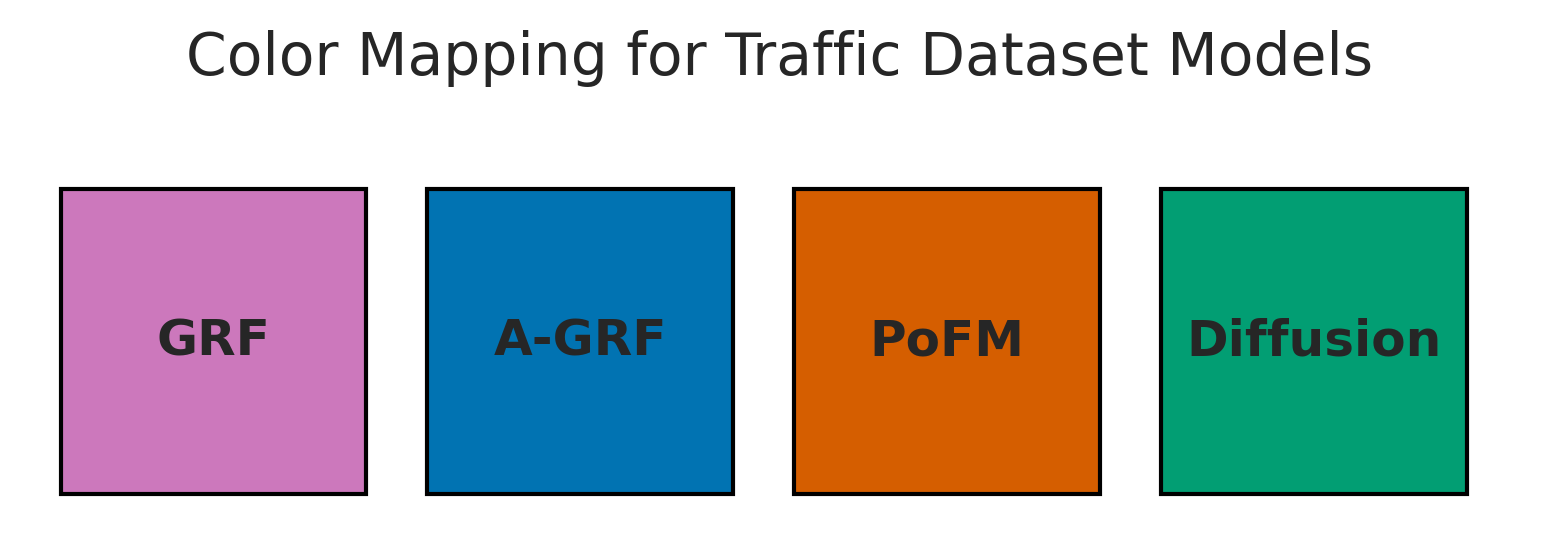


Full color palette (colorblind-friendly):
Index 0: RGB(1, 115, 178) / Hex: #0173b2
Index 1: RGB(222, 143, 5) / Hex: #de8f05
Index 2: RGB(2, 158, 115) / Hex: #029e73
Index 3: RGB(213, 94, 0) / Hex: #d55e00
Index 4: RGB(204, 120, 188) / Hex: #cc78bc


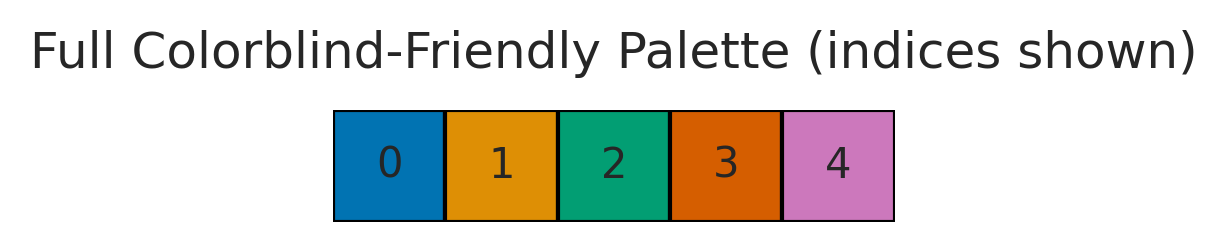

In [56]:
# Display the color mapping with actual color swatches
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

# Show color swatches for each model
x_pos = 0
for model, color in COLOR_MAPPING.items():
    # Draw color rectangle
    rect = plt.Rectangle((x_pos, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    
    # Add model label
    ax.text(x_pos + 0.5, 0.5, model, ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Print RGB values
    rgb = tuple(int(255 * c) for c in color[:3])
    print(f"{model}: RGB{rgb} / Hex: {mcolors.rgb2hex(color)}")
    
    x_pos += 1.2

ax.set_xlim(-0.1, x_pos)
ax.set_ylim(-0.1, 1.1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Color Mapping for Traffic Dataset Models', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Also show the full COLORS palette
print(f"\nFull color palette (colorblind-friendly):")
fig, ax = plt.subplots(1, 1, figsize=(10, 1))
for i, color in enumerate(COLORS):
    rect = plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    ax.text(i + 0.5, 0.5, f'{i}', ha='center', va='center', fontsize=10)
    rgb = tuple(int(255 * c) for c in color[:3])
    print(f"Index {i}: RGB{rgb} / Hex: {mcolors.rgb2hex(color)}")

ax.set_xlim(0, len(COLORS))
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Full Colorblind-Friendly Palette (indices shown)', fontsize=12, pad=10)
plt.tight_layout()
plt.show()

In [57]:
# Load the experiment results
try:
    df = pd.read_csv(RESULTS_FILE)
    print(f"Loaded {len(df)} results from {len(df['seed'].unique())} seeds")
    print(f"Models: {df['model'].unique()}")
    print(f"Seeds: {sorted(df['seed'].unique())}")
except FileNotFoundError:
    print(f"Results file not found: {RESULTS_FILE}")
    print("Please run the traffic_experiment.py script first to generate results.")
    df = None

if df is not None:
    # Display basic statistics
    print("\nBasic statistics:")
    print(df.groupby('model').agg({
        'rmse': ['mean', 'std'], 
        'nlpd': ['mean', 'std'],
        'lml': ['mean', 'std']
    }).round(4))

Loaded 150 results from 5 seeds
Models: ['PoFM' 'Diffusion' 'GRF' 'A-GRF']
Seeds: [1111, 1112, 1113, 1114, 1115]

Basic statistics:
              rmse             nlpd                lml         
              mean     std     mean      std      mean      std
model                                                          
A-GRF      14.9109  1.2833  97.1875   6.9104 -346.4638   6.3148
Diffusion  14.2915  1.1832  97.8942  12.0553 -352.5504  11.0684
GRF        15.3502  1.1945  98.8361   6.2473 -349.8005   4.1135
PoFM       14.1000  1.0807  93.0783   5.8060 -342.8276   2.6286


## Interactive Configuration

Configure which walks per node (wpn) values and seeds to include in the analysis.

In [58]:
# Configuration options - modify these to select specific data
if df is not None:
    # Available options
    available_seeds = sorted(df['seed'].unique())
    available_wpn = sorted(df[df['walks_per_node'].notna()]['walks_per_node'].unique())
    
    print("Available seeds:", available_seeds)
    print("Available walks per node values:", available_wpn)
    
    # CONFIGURE THESE VARIABLES TO FILTER DATA:
    
    # Select which seeds to include (set to None to include all)
    # Example: selected_seeds = [42, 123] to include only seeds 42 and 123
    selected_seeds = None  # None means include all seeds
    
    # Select which walks per node values to include (set to None to include all)  
    selected_wpn = None
    
    # Apply filters
    filtered_df = df.copy()
    
    if selected_seeds is not None:
        filtered_df = filtered_df[filtered_df['seed'].isin(selected_seeds)]
        print(f"\nFiltered to seeds: {selected_seeds}")
    
    if selected_wpn is not None:
        # Keep baseline models (wpn is NaN) and selected wpn values
        mask = (filtered_df['walks_per_node'].isna()) | (filtered_df['walks_per_node'].isin(selected_wpn))
        filtered_df = filtered_df[mask]
        print(f"Filtered to wpn values: {selected_wpn}")
    
    print(f"\nFiltered dataset: {len(filtered_df)} rows (originally {len(df)} rows)")
    print(f"Remaining seeds: {sorted(filtered_df['seed'].unique())}")
    
    # Keep original df for processing, store filtered version for visualization
    df_original = df.copy()  # Keep original for reference
    df_filtered = filtered_df  # This will be used for visualization only
else:
    print("No data loaded - cannot configure filters")
    df_filtered = None

Available seeds: [1111, 1112, 1113, 1114, 1115]
Available walks per node values: [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0]

Filtered dataset: 150 rows (originally 150 rows)
Remaining seeds: [1111, 1112, 1113, 1114, 1115]


## Data Processing and Summary Statistics

In [59]:
def process_grf_data(df):
    """Process GRF data for plotting with error bars"""
    if df is None:
        return None, None
    
    # Separate GRF models (those with walks_per_node values)
    grf_data = df[df['walks_per_node'].notna()].copy()
    
    # Calculate mean, std, and count for each model and walks_per_node
    grf_stats = grf_data.groupby(['model', 'walks_per_node']).agg({
        'rmse': ['mean', 'std', 'count'],
        'nlpd': ['mean', 'std', 'count'],
        'lml': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    grf_stats.columns = ['model', 'walks_per_node', 'rmse_mean', 'rmse_std', 'rmse_count',
                         'nlpd_mean', 'nlpd_std', 'nlpd_count', 'lml_mean', 'lml_std', 'lml_count']
    
    # Handle NaN standard deviations (when only one seed)
    grf_stats = grf_stats.fillna(0)
    
    # Adjust error bars by dividing by sqrt(number of trials)
    grf_stats['rmse_stderr'] = grf_stats['rmse_std'] / np.sqrt(grf_stats['rmse_count'])
    grf_stats['nlpd_stderr'] = grf_stats['nlpd_std'] / np.sqrt(grf_stats['nlpd_count'])
    grf_stats['lml_stderr'] = grf_stats['lml_std'] / np.sqrt(grf_stats['lml_count'])
    
    return grf_stats, grf_data

def get_baseline_stats(df):
    """Get baseline model statistics"""
    if df is None:
        return None
    
    baselines = df[df['walks_per_node'].isna()].copy()
    # Exclude PoFM from baselines
    baselines = baselines[baselines['model'] != 'PoFM']
    
    baseline_stats = baselines.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'nlpd': ['mean', 'std', 'count'],
        'lml': ['mean', 'std', 'count']
    }).reset_index()
    
    baseline_stats.columns = ['model', 'rmse_mean', 'rmse_std', 'rmse_count',
                             'nlpd_mean', 'nlpd_std', 'nlpd_count', 'lml_mean', 'lml_std', 'lml_count']
    baseline_stats = baseline_stats.fillna(0)
    
    # Adjust error bars by dividing by sqrt(number of trials)
    baseline_stats['rmse_stderr'] = baseline_stats['rmse_std'] / np.sqrt(baseline_stats['rmse_count'])
    baseline_stats['nlpd_stderr'] = baseline_stats['nlpd_std'] / np.sqrt(baseline_stats['nlpd_count'])
    baseline_stats['lml_stderr'] = baseline_stats['lml_std'] / np.sqrt(baseline_stats['lml_count'])
    
    return baseline_stats

# Process all data for full statistics
if df is not None:
    grf_stats_all, grf_data_all = process_grf_data(df)
    baseline_stats_all = get_baseline_stats(df)
    
    print("\nFull Dataset - GRF Models Summary:")
    if grf_stats_all is not None:
        print(grf_stats_all[['model', 'walks_per_node', 'rmse_mean', 'rmse_std', 'nlpd_mean', 'nlpd_std']].head(10))
    
    print("\nFull Dataset - Baseline Models Summary:")
    if baseline_stats_all is not None:
        print(baseline_stats_all[['model', 'rmse_mean', 'rmse_std', 'nlpd_mean', 'nlpd_std']])

# Process filtered data for visualization
if df_filtered is not None:
    grf_stats, grf_data = process_grf_data(df_filtered)
    baseline_stats = get_baseline_stats(df_filtered)
    
    print("\nFiltered Dataset - GRF Models Summary:")
    if grf_stats is not None:
        print(grf_stats[['model', 'walks_per_node', 'rmse_mean', 'rmse_std', 'nlpd_mean', 'nlpd_std']].head(10))
    
    print("\nFiltered Dataset - Baseline Models Summary:")
    if baseline_stats is not None:
        print(baseline_stats[['model', 'rmse_mean', 'rmse_std', 'nlpd_mean', 'nlpd_std']])
else:
    grf_stats, grf_data = None, None
    baseline_stats = None


Full Dataset - GRF Models Summary:
   model  walks_per_node  rmse_mean  rmse_std   nlpd_mean  nlpd_std
0  A-GRF             1.0  16.102212  1.240718  102.783588  7.161148
1  A-GRF             2.0  15.948195  0.965643  100.420080  5.226771
2  A-GRF             4.0  16.130992  0.837194  101.146201  4.293753
3  A-GRF             8.0  16.020908  1.023459  101.488408  5.518571
4  A-GRF            16.0  14.903664  0.857368   99.424889  7.659625
5  A-GRF            32.0  15.407923  1.299593  100.707718  6.838225
6  A-GRF            64.0  14.956944  0.983894   99.024314  7.394254
7  A-GRF           128.0  14.627582  1.172608   96.066555  6.951233
8  A-GRF           256.0  14.613968  0.939900   95.054881  4.925189
9  A-GRF           512.0  14.095750  0.972623   92.013256  4.183413

Full Dataset - Baseline Models Summary:
       model  rmse_mean  rmse_std  nlpd_mean   nlpd_std
0  Diffusion  14.291479  1.183158  97.894177  12.055301

Filtered Dataset - GRF Models Summary:
   model  walks_per_nod

## Visualization: RMSE vs Number of Walkers

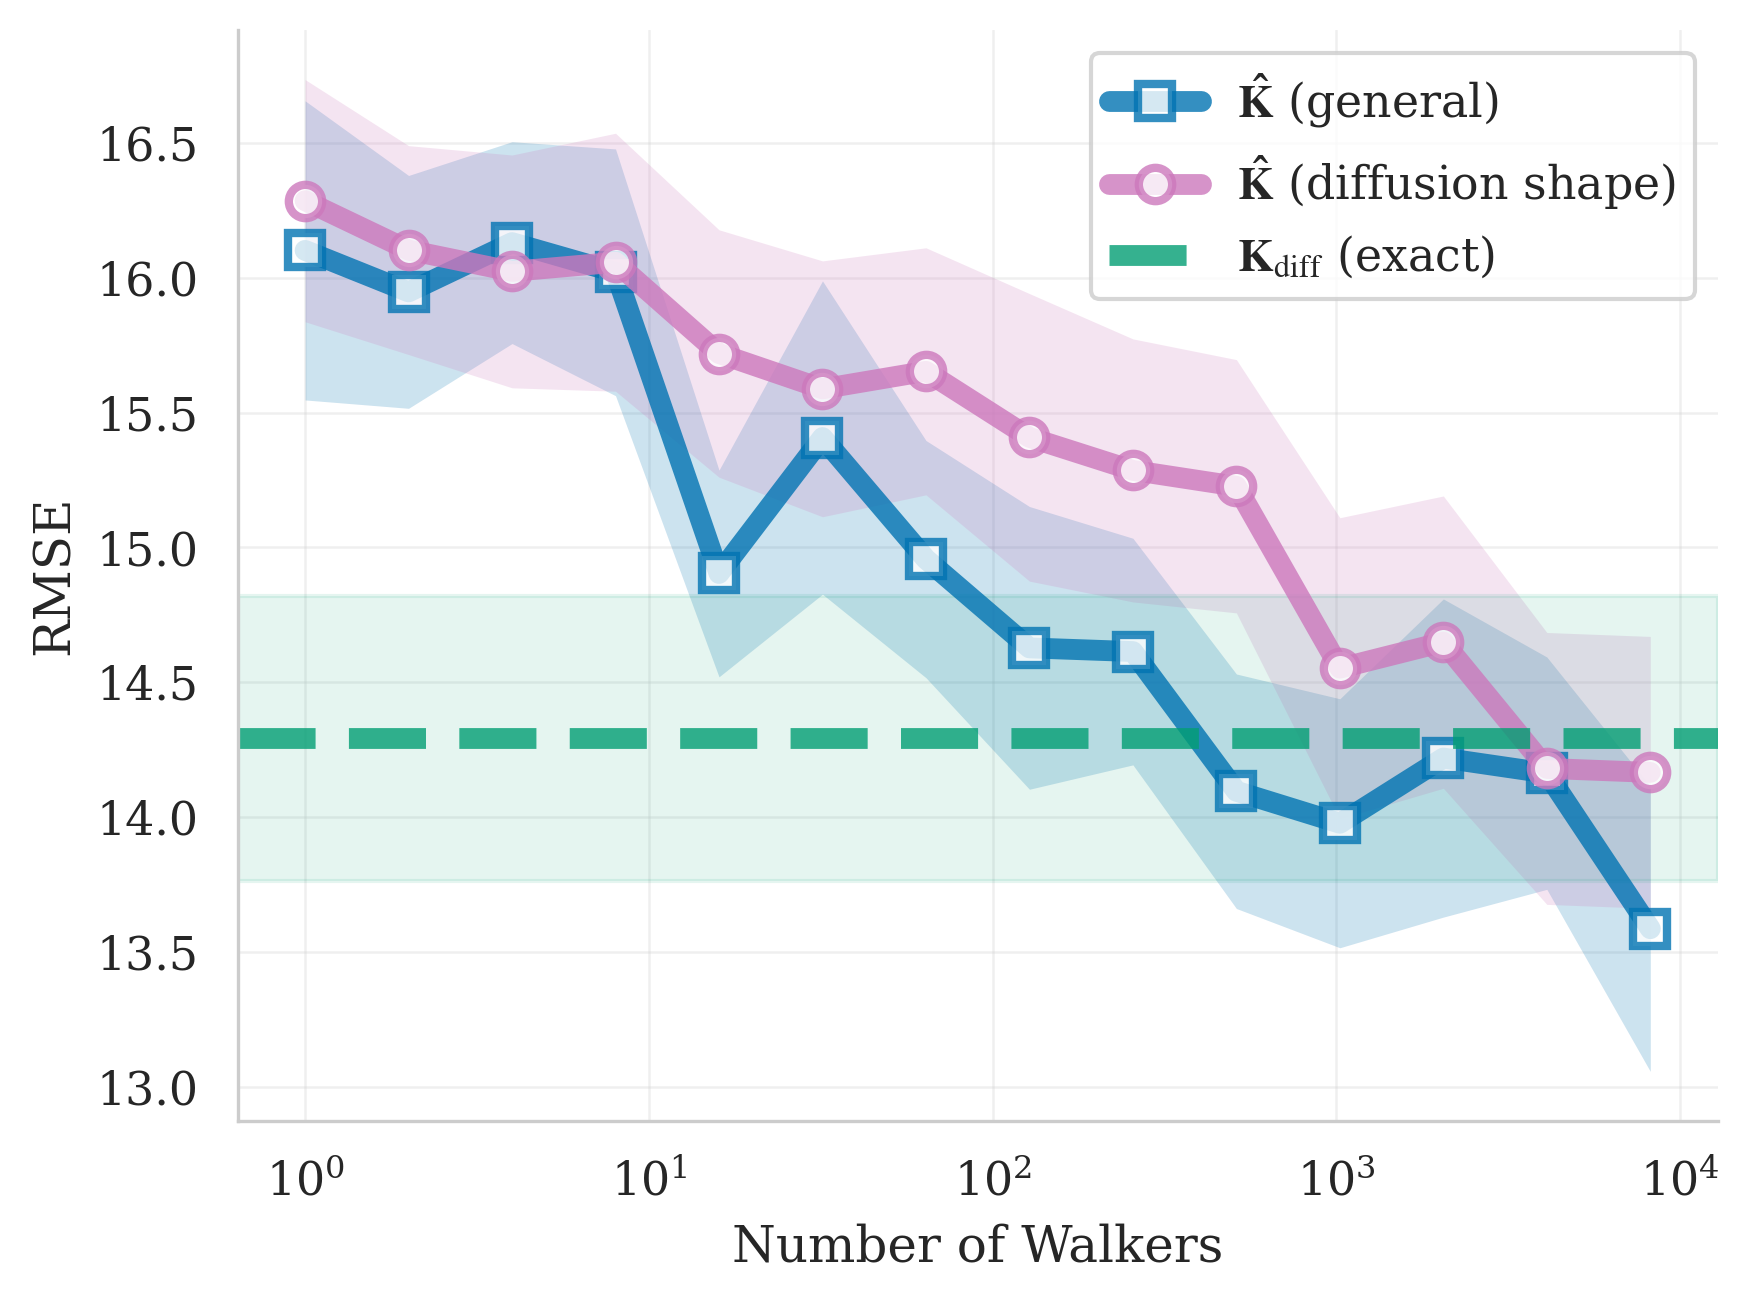

In [60]:
def plot_rmse_vs_walkers(grf_stats, baseline_stats, figsize=(6, 4.5)):
    """Plot RMSE vs Number of Walkers with error bars"""
    # Set publication-style formatting (ICLR compatible)
    import matplotlib as mpl
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "font.family": "serif",
        "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "grid.alpha": 0.3,
        "text.usetex": False,  # Set to True if LaTeX is available
        "mathtext.fontset": "stix",  # STIX fonts for math (Times-compatible)
    })
    
    plt.figure(figsize=figsize)
    
    # Line width for consistency with BO notebook
    lw = 5
    ms = 8  # marker size
    mew = 2  # marker edge width
    
    # Define marker shapes and labels for each model
    model_config = {
        'GRF': {'marker': 'o', 'label': r"$\mathbf{\hat{K}}$ (diffusion shape)"},
        'A-GRF': {'marker': 's', 'label': r"$\mathbf{\hat{K}}$ (general)"},
        'PoFM': {'marker': '^', 'label': 'PoFM'},
        'Diffusion': {'marker': 'D', 'label': r"$\mathbf{K}_{\text{diff}}$ (exact)"}
    }
    
    if grf_stats is not None:
        # Plot GRF models
        for model in grf_stats['model'].unique():
            model_data = grf_stats[grf_stats['model'] == model].sort_values('walks_per_node')
            config = model_config.get(model, {'marker': 'o', 'label': model})
            
            plt.plot(
                model_data['walks_per_node'], 
                model_data['rmse_mean'],
                marker=config['marker'],
                markersize=ms,
                markerfacecolor='white',
                markeredgewidth=mew,
                linestyle='-', 
                linewidth=lw,
                color=COLOR_MAPPING.get(model, 'gray'),
                alpha=0.8,
                label=config['label']
            )
            
            # Add shaded error region using stderr
            plt.fill_between(
                model_data['walks_per_node'],
                model_data['rmse_mean'] - model_data['rmse_stderr'],
                model_data['rmse_mean'] + model_data['rmse_stderr'],
                alpha=0.2,
                color=COLOR_MAPPING.get(model, 'gray'),
                linewidth=0
            )
    
    # Plot baseline horizontal lines
    if baseline_stats is not None:
        for _, row in baseline_stats.iterrows():
            model = row['model']
            mean_val = row['rmse_mean']
            stderr_val = row['rmse_stderr']
            config = model_config.get(model, {'label': f"{model} (exact)"})
            
            # Horizontal line for mean
            plt.axhline(
                y=mean_val, 
                color=COLOR_MAPPING.get(model, 'gray'), 
                linestyle='--', 
                linewidth=lw,
                alpha=0.8,
                label=config['label']
            )
            
            # Shaded region for stderr
            if stderr_val > 0:
                plt.axhspan(
                    mean_val - stderr_val, 
                    mean_val + stderr_val, 
                    alpha=0.1, 
                    color=COLOR_MAPPING.get(model, 'gray')
                )
    
    plt.xlabel('Number of Walkers')
    plt.ylabel('RMSE')
    plt.xscale('log')
    plt.legend(loc='upper right')
    
    # Grid styling to match BO notebook
    plt.grid(True, which="major", axis="both")
    
    # Clean spines like BO notebook
    ax = plt.gca()
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.show()

if df is not None and grf_stats is not None:
    plot_rmse_vs_walkers(grf_stats, baseline_stats)
else:
    print("No data available for RMSE plot")

## Visualization: NLPD vs Number of Walkers

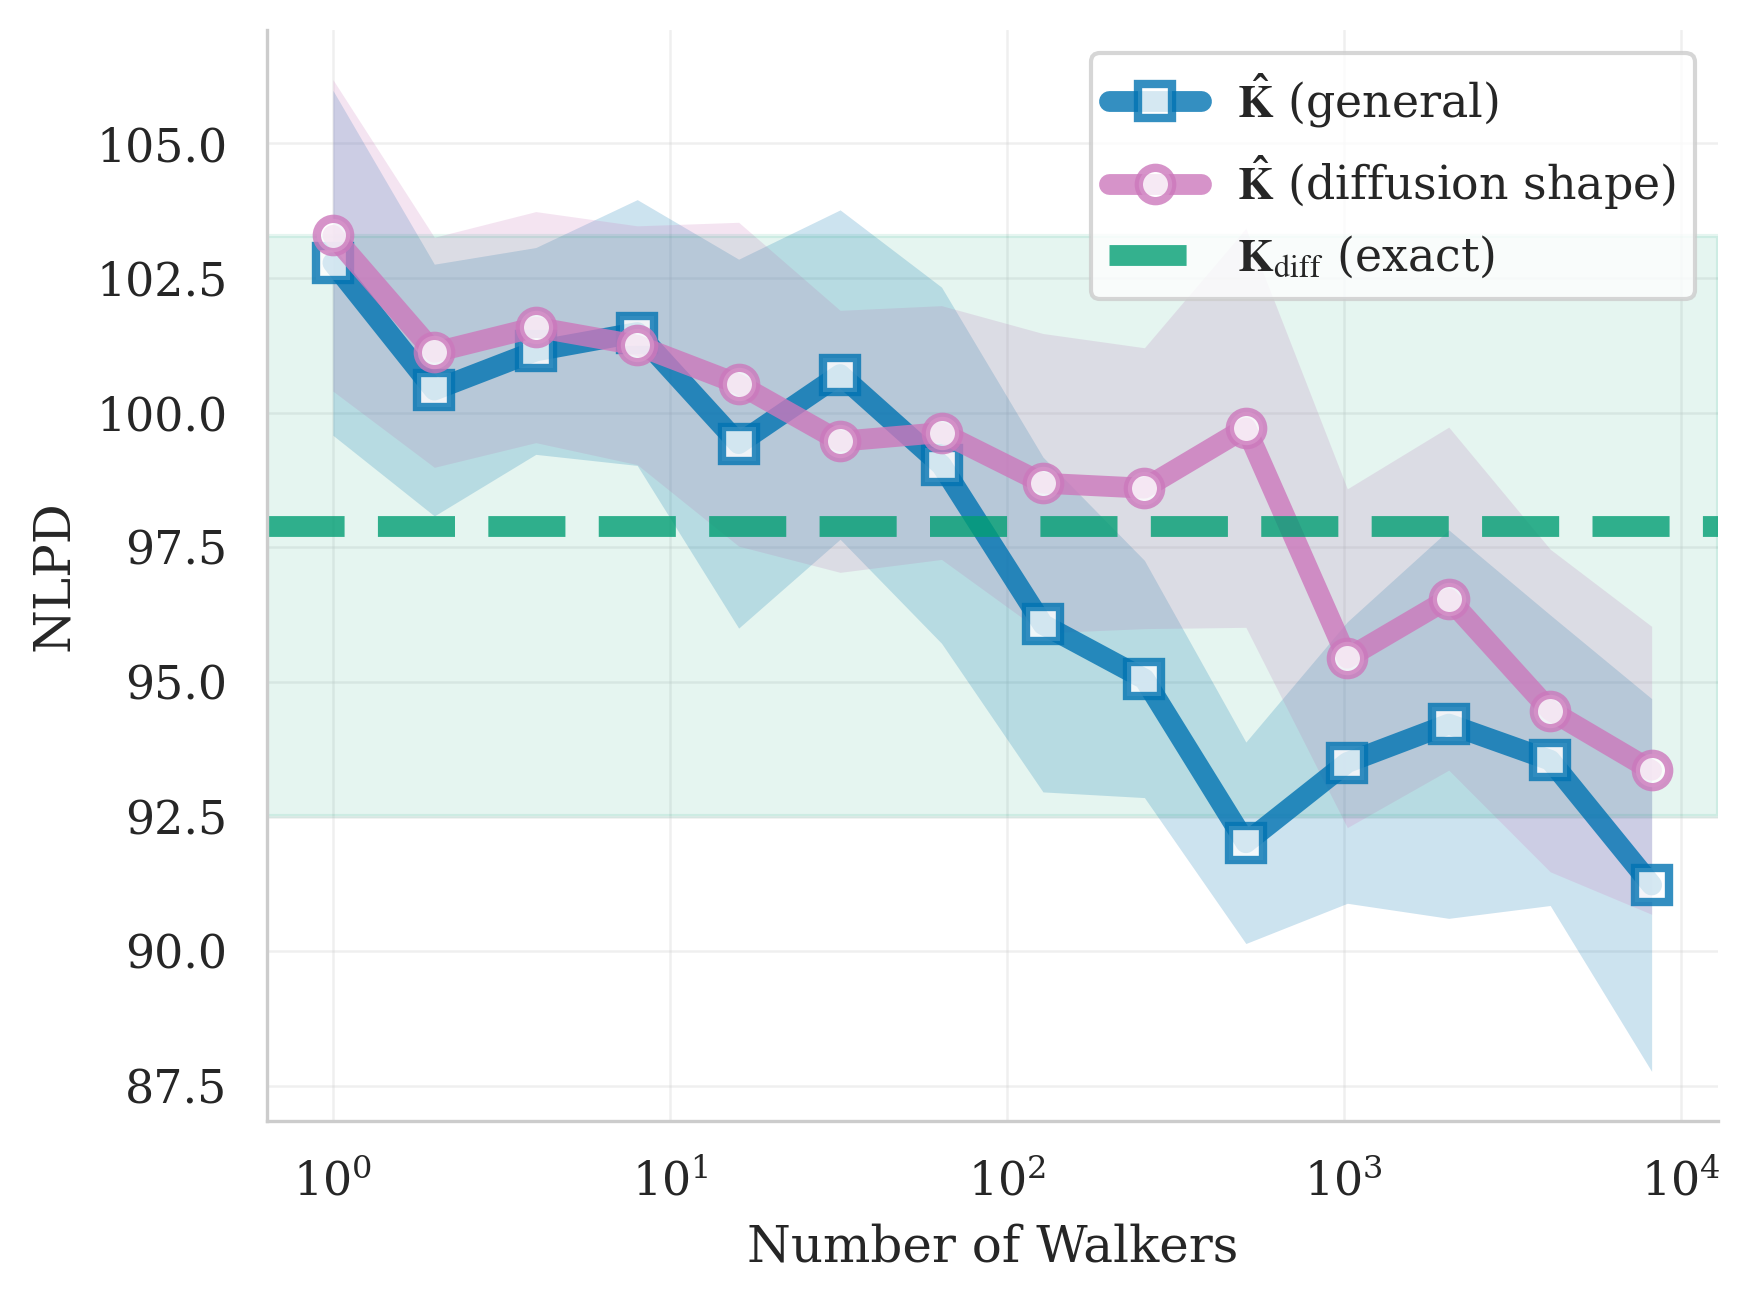

In [61]:
def plot_nlpd_vs_walkers(grf_stats, baseline_stats, figsize=(6, 4.5)):
    """Plot NLPD vs Number of Walkers with error bars"""
    # Set publication-style formatting (ICLR compatible)
    import matplotlib as mpl
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "font.family": "serif",
        "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "grid.alpha": 0.3,
        "text.usetex": False,  # Set to True if LaTeX is available
        "mathtext.fontset": "stix",  # STIX fonts for math (Times-compatible)
    })
    
    plt.figure(figsize=figsize)
    
    # Line width for consistency with BO notebook
    lw = 5
    ms = 8  # marker size
    mew = 2  # marker edge width
    
    # Define marker shapes and labels for each model
    model_config = {
        'GRF': {'marker': 'o', 'label': r"$\mathbf{\hat{K}}$ (diffusion shape)"},
        'A-GRF': {'marker': 's', 'label': r"$\mathbf{\hat{K}}$ (general)"},
        'PoFM': {'marker': '^', 'label': 'PoFM'},
        'Diffusion': {'marker': 'D', 'label': r"$\mathbf{K}_{\text{diff}}$ (exact)"}
    }
    
    if grf_stats is not None:
        # Plot GRF models
        for model in grf_stats['model'].unique():
            model_data = grf_stats[grf_stats['model'] == model].sort_values('walks_per_node')
            config = model_config.get(model, {'marker': 'o', 'label': model})
            
            plt.plot(
                model_data['walks_per_node'], 
                model_data['nlpd_mean'],
                marker=config['marker'],
                markersize=ms,
                markerfacecolor='white',
                markeredgewidth=mew,
                linestyle='-', 
                linewidth=lw,
                color=COLOR_MAPPING.get(model, 'gray'),
                alpha=0.8,
                label=config['label']
            )
            
            # Add shaded error region using stderr
            plt.fill_between(
                model_data['walks_per_node'],
                model_data['nlpd_mean'] - model_data['nlpd_stderr'],
                model_data['nlpd_mean'] + model_data['nlpd_stderr'],
                alpha=0.2,
                color=COLOR_MAPPING.get(model, 'gray'),
                linewidth=0
            )
    
    # Plot baseline horizontal lines
    if baseline_stats is not None:
        for _, row in baseline_stats.iterrows():
            model = row['model']
            mean_val = row['nlpd_mean']
            stderr_val = row['nlpd_stderr']
            config = model_config.get(model, {'label': f"{model} (exact)"})
            
            # Horizontal line for mean
            plt.axhline(
                y=mean_val, 
                color=COLOR_MAPPING.get(model, 'gray'), 
                linestyle='--', 
                linewidth=lw,
                alpha=0.8,
                label=config['label']
            )
            
            # Shaded region for stderr
            if stderr_val > 0:
                plt.axhspan(
                    mean_val - stderr_val, 
                    mean_val + stderr_val, 
                    alpha=0.1, 
                    color=COLOR_MAPPING.get(model, 'gray')
                )
    
    plt.xlabel('Number of Walkers')
    plt.ylabel('NLPD')
    plt.xscale('log')
    plt.legend(loc='upper right')
    
    # Grid styling to match BO notebook
    plt.grid(True, which="major", axis="both")
    
    # Clean spines like BO notebook
    ax = plt.gca()
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.show()

if df is not None and grf_stats is not None:
    plot_nlpd_vs_walkers(grf_stats, baseline_stats)
else:
    print("No data available for NLPD plot")